# Neural Network for MNIST Classification

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.4.0


### Load data

* **as_supervised=True** : Loads the data in a 2-tuple structure (input, target)
* **with_info=True** : Provides a tuple containing info about version, features, number of samples

In [3]:
mnist_datasets, mnist_info = tfds.load('mnist', with_info=True, as_supervised=True)

mnist_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='C:\\Users\\della\\tensorflow_datasets\\mnist\\3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

### Plot the images

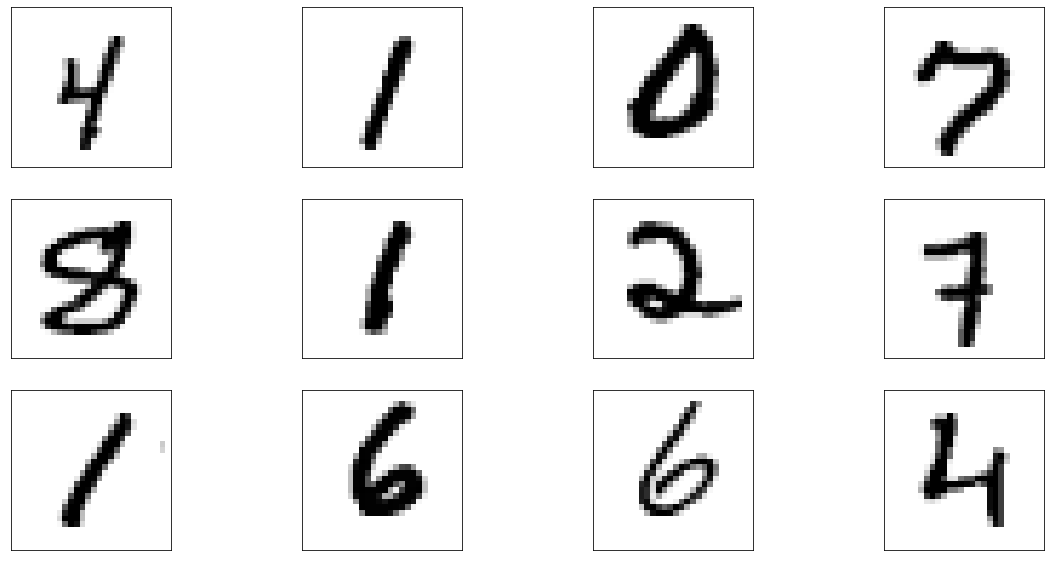

In [44]:
data = iter(mnist_datasets['train'])

plt.figure(figsize=(20,10))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(next(data)[0], cmap=plt.cm.binary)

### Preprocessing

* By default, MNIST has a train and a test datasets, but no validation dataset. Thus, we must split the train dataset. 
* We define the number of validation samples as a % of the train samples (here 10 %).

In [4]:
mnist_train, mnist_test = mnist_datasets['train'], mnist_datasets['test']
print('Number of train samples : ' + str(mnist_info.splits['train'].num_examples))

num_validation_samples = 0.1 * mnist_info.splits['train'].num_examples
num_validation_samples = tf.cast(num_validation_samples, tf.int64)
num_validation_samples
print('Number of validation samples : ' + str(num_validation_samples))

num_test_samples = mnist_info.splits['test'].num_examples
num_test_samples = tf.cast(num_test_samples, tf.int64)
num_test_samples
print('Number of test samples : ' + str(num_test_samples))

Number of train samples : 60000
Number of validation samples : tf.Tensor(6000, shape=(), dtype=int64)
Number of test samples : tf.Tensor(10000, shape=(), dtype=int64)


We normalize the inputs between 0 and 1. In order to do so, we will use the following method :

* **.map()** : Allows us to apply a custom function to a given dataset

In [5]:
def scale(image, label):
    image = tf.cast(image, tf.float32)
    image /= 255.
    return image, label

scaled_train_and_validation = mnist_train.map(scale)

test_data = mnist_test.map(scale)

* **.shuffle()** : Randomly shuffles the elements of this dataset.
* **.take()** : Creates a Dataset with at most count elements from this dataset.
* **.skip()** : Creates a Dataset that skips count elements from this dataset.

There is no need to shuffle the test dataset since it will not train the model.

BUFFER_SIZE is used if we can't shuffle the whole dataset in one because we can't fit it all in memory. In this case, we only stores BUFFER_SIZE samples in memory at a time and shuffles them.

* If BUFFER_SIZE = 1, there is no shuffling 
* If BUFFER_SIZE >= number of samples, the shuffling is uniform

In [7]:
BUFFER_SIZE = 10000

shuffled_train_and_validation_data = scaled_train_and_validation.shuffle(BUFFER_SIZE)

validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

The model expects the validation and test datasets in batch form too.

* **.batch()** : Combines consecutive elements of this dataset into batches.

In [8]:
BATCH_SIZE = 100

train_data = train_data.batch(BATCH_SIZE)
validation_data = validation_data.batch(num_validation_samples)
test_data = test_data.batch(num_test_samples)

* **iter()** : Create a iterable object.
* **next()** : Loads the next element of an iterable object. Because there is only 1 batch here, this will load the data.

In [9]:
validation_inputs, validation_targets = next(iter(validation_data))

### Model

#### Outline the model

In [75]:
input_size = 784
output_size = 10
hidden_layer_size = 80

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28,1)),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'),
    tf.keras.layers.Dense(output_size, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 80)                62800     
_________________________________________________________________
dense_4 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_5 (Dense)              (None, 80)                6480      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                810       
Total params: 76,570
Trainable params: 76,570
Non-trainable params: 0
_________________________________________________________________


#### Choose the optimizer and the loss function

In [76]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Training

In [77]:
NUM_EPOCHS = 8

history = model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose=2)

Epoch 1/8
540/540 - 4s - loss: 0.3502 - accuracy: 0.8999 - val_loss: 0.1634 - val_accuracy: 0.9517
Epoch 2/8
540/540 - 3s - loss: 0.1368 - accuracy: 0.9598 - val_loss: 0.1228 - val_accuracy: 0.9635
Epoch 3/8
540/540 - 3s - loss: 0.0994 - accuracy: 0.9696 - val_loss: 0.0934 - val_accuracy: 0.9740
Epoch 4/8
540/540 - 4s - loss: 0.0785 - accuracy: 0.9762 - val_loss: 0.0726 - val_accuracy: 0.9798
Epoch 5/8
540/540 - 3s - loss: 0.0625 - accuracy: 0.9808 - val_loss: 0.0711 - val_accuracy: 0.9775
Epoch 6/8
540/540 - 3s - loss: 0.0519 - accuracy: 0.9839 - val_loss: 0.0717 - val_accuracy: 0.9770
Epoch 7/8
540/540 - 3s - loss: 0.0445 - accuracy: 0.9861 - val_loss: 0.0565 - val_accuracy: 0.9830
Epoch 8/8
540/540 - 3s - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0425 - val_accuracy: 0.9870


#### Plot learning curves

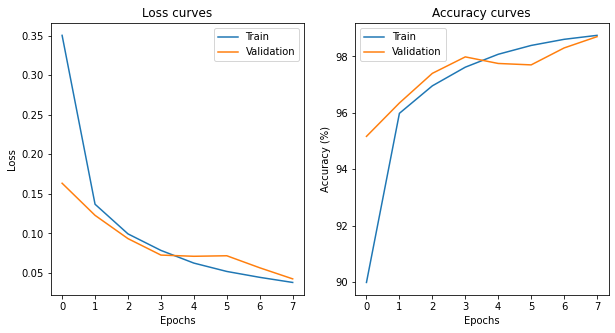

In [78]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')

plt.subplot(1,2,2)
plt.plot(np.array(history.history['accuracy']) * 100, label='Train')
plt.plot(np.array(history.history['val_accuracy']) * 100, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy curves')

plt.show()

### Test the model

In [79]:
test_loss, test_accuracy = model.evaluate(test_data)

print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

1/1 [==============================] - 1s 646ms/step - loss: 0.0869 - accuracy: 0.9735
Test loss: 0.09. Test accuracy: 97.35%


### Plot the hidden layers

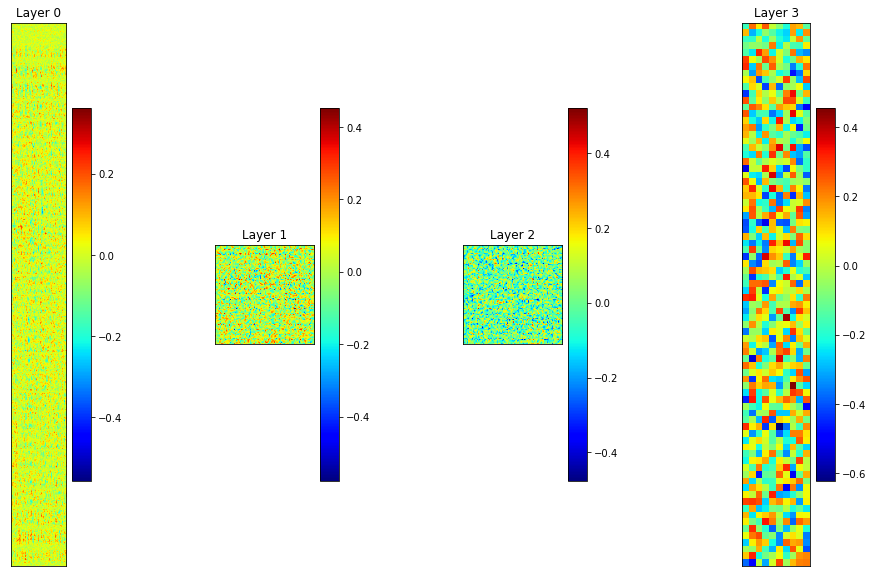

In [102]:
plt.figure(figsize=(20,10))

for i, layer in zip(range(len(model.layers)), model.layers[1:]):
    weights, biases = layer.get_weights()
    
    plt.subplot(1, len(model.layers), i + 1)
    plt.imshow(weights, cmap='jet')  
    plt.title('Layer ' + str(i))
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
plt.subplots_adjust(wspace=1)
plt.show()